# Inactive REpressor Binding Approach

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.viz
import mut.stats
import pystan
colors = mut.viz.color_selector('pboc')
mut.viz.plotting_style()
%load_ext stanmagic

In [87]:
# Load teh data
data = pd.read_csv('../../data/csv/RazoMejia2018_data.csv', comment='#')
old = pd.read_csv('../../data/csv/Garcia2011_Brewster2014_data.csv', comment='#')

In [88]:
data['repressors'] *= 2
data['IPTG_uM'] = data['IPTG_uM'] / 1E6
data.rename(columns={'fold_change_A':'fold_change', 'IPTG_uM':'IPTGuM'}, inplace=True)

In [130]:
def ri_induction(R, c, epRA):
    ki = 2.5E5
    ka = 0.03 * ki
    epAI = 0.35
    L = 0.7
    p_act = (1 + c*ka)**2 / ((1 + c * ka)**2 + L * (1 + c * ki)**2)
    return (1 + (R / 4.6E6)*(p_act * np.exp(-epRA) + (1 - p_act)*np.exp(-(epRA+7))))**-1
    

In [125]:
model_code = """

data {
    int<lower=1> N;
    real<lower=1> R[N];
    real<lower=0> c[N];
    real ka;
    real ki;
    real L;
    vector[N] fc; 
}

parameters { 
    real epRA;
    real sigma;
}

model {
    vector[N] mu;
    real pact[N];
    
    epRA ~ normal(12, 6);
    sigma ~ normal(0, 0.1);
    
    for (i in 1:N) { 
        pact[i] = (1 + c[i] * ka)^2 / ((1 + c[i]*ka)^2 +  L * (1 + c[i]*ki)^2);
        mu[i] = (1 + (R[i] / 4600000) * (pact[i] * exp(-epRA) + (1 - pact[i]) * exp(-(epRA + 7))))^-1;
    }
    
    fc ~ normal(mu, sigma);
}
"""
model  = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8db90f61e8cdefd36fd1c1934eba7be NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp70xpr22l/stanfit4anon_model_c8db90f61e8cdefd36fd1c1934eba7be_4893534353565146070.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


## Approach 1: Repressor Titration

The first approach is to try and fit the two binding energies via the repressor titration curve. We'll use combined brewster and hernan data to get a better estimate of the binding energy. 

In [211]:
O2 = old[old['operator']=='O2']
data_dict = {'N':len(O2),
             'R':O2['repressor'],
             'c':np.zeros(len(O2)),
              'fc':O2['fold_change'],
            'ki':2.5E5, 'ka':0.03*2.5E5,
            'L':0.7}
fit = model.sampling(data_dict)

In [212]:
newO2 = -14.4
newO1 = -15.9
newO3 = -9.3

In [213]:
fit

Inference for Stan model: anon_model_c8db90f61e8cdefd36fd1c1934eba7be.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
epRA  -14.36  1.3e-3   0.06 -14.48  -14.4 -14.36 -14.32 -14.25   2102    1.0
sigma   0.03  1.5e-4 4.8e-3   0.02   0.02   0.03   0.03   0.04    994    1.0
lp__   50.77    0.04   1.15  47.67  50.34  51.14   51.6  51.88    861    1.0

Samples were drawn using NUTS at Wed May 22 19:32:20 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

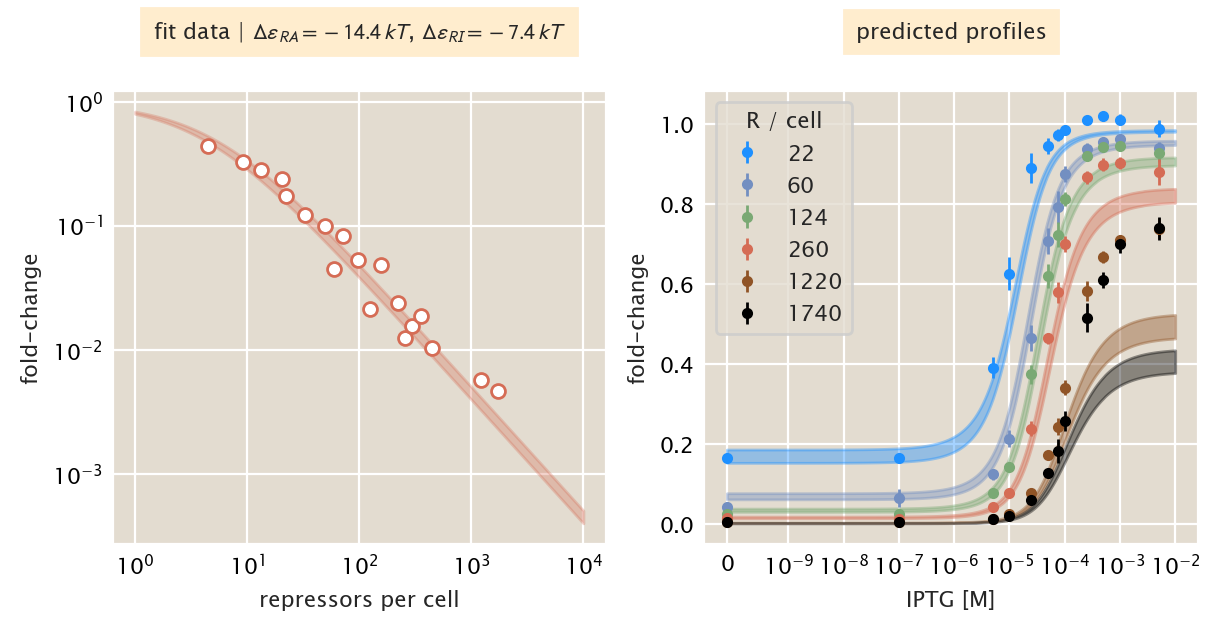

In [214]:
data = data[data['repressors'] > 0]
O2_razo = data[data['operator']=='O2'].groupby(['IPTGuM', 'repressors'])['fold_change'].agg(('mean', 'sem')).reset_index()
fit_df = fit.to_dataframe()
stats = mut.stats.compute_statistics(fit_df, varnames=['epRA'], logprob_name='lp__')


# Plot the fits and the predictions
fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)

ax[0].loglog(O2['repressor'], O2['fold_change'], 'o', ms=5, color=colors['red'], markerfacecolor='w')
rep_colors = {22:'dodgerblue', 60:colors['blue'], 124:colors['green'], 260:colors['red'], 1220:colors['dark_brown'], 1740:'k'}
for g, d in O2_razo.groupby(['repressors']):
    ax[1].errorbar(d['IPTGuM'], d['mean'], d['sem'], fmt='.', lw=1,  linestyle='none',
                  color=rep_colors[g], label=int(g))


# Compute the fit curves
r_range = np.logspace(0, 4, 200)
c_range = np.logspace(-9, -2, 200)
c_range[0] = 0
r_cred_region = np.zeros((2, len(r_range)))
for i, r in enumerate(r_range):
    fc = ri_induction(r, 0, fit_df['epRA'])
    r_cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    
ax[0].fill_between(r_range, r_cred_region[0], r_cred_region[1], color=colors['red'], alpha=0.3)    

for g, d in O2_razo.groupby(['repressors']):
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        fc = ri_induction(g, c, fit_df['epRA'])
        cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    ax[1].fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.4,
                       color=rep_colors[g], label='__nolegend__')

ax[1].set_xscale('symlog', linthreshx=1E-4)
leg = ax[1].legend(title = 'R / cell', loc='upper left', fontsize=8)
leg.get_title().set_fontsize(8)
ax[0].set_xlabel('repressors per cell', fontsize=8)
ax[0].set_ylabel('fold-change', fontsize=8)
ax[1].set_ylabel('fold-change', fontsize=8)
ax[1].set_xlabel('IPTG [M]', fontsize=8)
ax[0].set_title(r'fit data | $\Delta\varepsilon_{RA} = -14.4\, kT$, $\Delta\varepsilon_{RI} =-7.4\, kT$', fontsize=8, backgroundcolor=colors['pale_yellow'], y=1.08)
ax[1].set_title('predicted profiles', fontsize=8, backgroundcolor=colors['pale_yellow'], y=1.08)
for a in ax:
    a.xaxis.set_tick_params(labelsize=8)
    a.yaxis.set_tick_params(labelsize=8)
ax[1].set_xscale('symlog', linthreshx=1E-9)
plt.savefig('./repressor_titration_epRA_fitting.pdf', bbox_inches='tight')

## Approach 2: Fit induction profile. 

In [215]:
fit_data = data[(data['repressors']==260) & (data['operator']=='O2')]
data_dict = {'N':len(fit_data),
             'R':fit_data['repressors'],
             'c':fit_data['IPTGuM'].values,
              'fc':fit_data['fold_change'],
              'ki':2.5E5,
               'ka':0.03 * 2.5E5,
               'L':0.7}
ind_fit = model.sampling(data_dict, iter=5000, control=dict(adapt_delta=0.95))

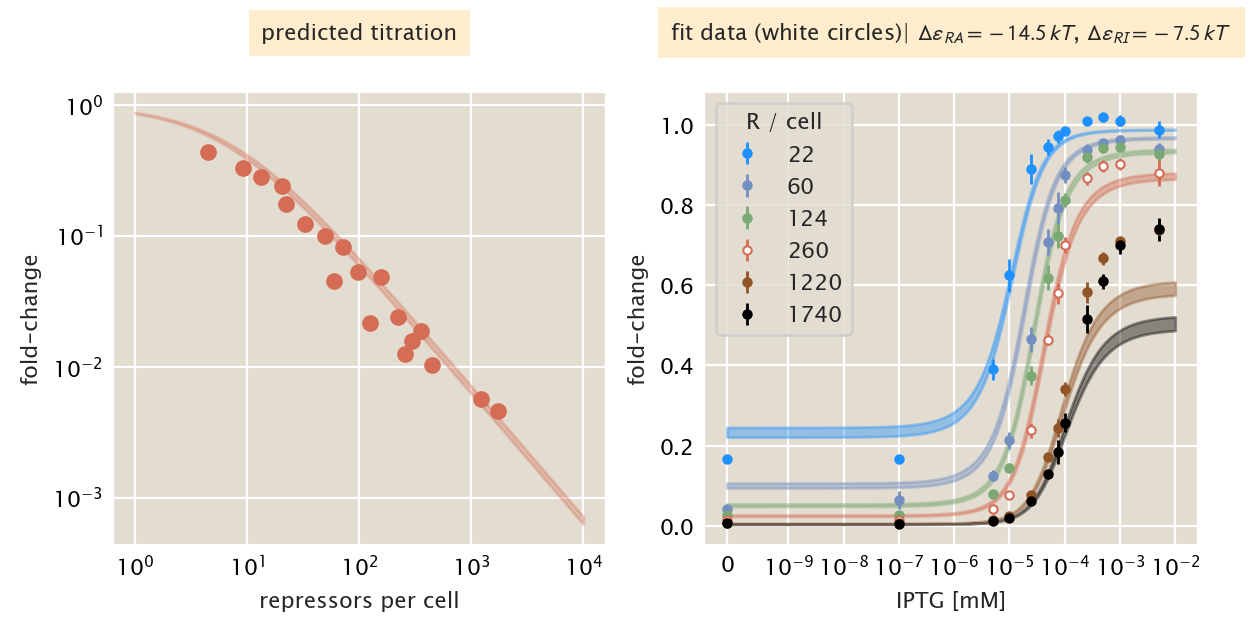

In [216]:
data = data[data['repressors'] > 0]
O2_razo = data[data['operator']=='O2'].groupby(['IPTGuM', 'repressors'])['fold_change'].agg(('mean', 'sem')).reset_index()
fit_df = ind_fit.to_dataframe()
stats = mut.stats.compute_statistics(fit_df, varnames=['epRA'], logprob_name='lp__')


# Plot the fits and the predictions
fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)

ax[0].loglog(O2['repressor'], O2['fold_change'], 'o', ms=5, color=colors['red'])
rep_colors = {22:'dodgerblue', 60:colors['blue'], 124:colors['green'], 260:colors['red'], 1220:colors['dark_brown'], 1740:'k'}
for g, d in O2_razo.groupby(['repressors']):
    if g == 260:
        face = 'w'
    else:
        face = rep_colors[g]
    ax[1].errorbar(d['IPTGuM'], d['mean'], d['sem'], fmt='.', lw=1,  linestyle='none',
                  color=rep_colors[g], label=int(g), markerfacecolor=face, markeredgewidth=0.75)


# Compute the fit curves
r_range = np.logspace(0, 4, 200)
c_range = np.logspace(-10, -2, 200)
c_range[0] = 0
r_cred_region = np.zeros((2, len(r_range)))
for i, r in enumerate(r_range):

    fc = ri_induction(r, 0, fit_df['epRA']) 
    r_cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    
ax[0].fill_between(r_range, r_cred_region[0], r_cred_region[1], color=colors['red'], alpha=0.3)    

for g, d in O2_razo.groupby(['repressors']):
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        fc = ri_induction(g, c, fit_df['epRA'])
        cred_region[:, i] = mut.stats.compute_hpd(fc, 0.95)
    ax[1].fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.4,
                       color=rep_colors[g], label='__nolegend__')

ax[1].set_xscale('symlog', linthreshx=1E-9)
leg = ax[1].legend(title = 'R / cell', loc='upper left', fontsize=8)
leg.get_title().set_fontsize(8)
ax[0].set_xlabel('repressors per cell', fontsize=8)
ax[0].set_ylabel('fold-change', fontsize=8)
ax[1].set_ylabel('fold-change', fontsize=8)
ax[1].set_xlabel('IPTG [mM]', fontsize=8)
ax[1].set_title(r'fit data (white circles)| $\Delta\varepsilon_{RA} = -14.5\, kT$, $\Delta\varepsilon_{RI} =-7.5\, kT$', fontsize=8, backgroundcolor=colors['pale_yellow'], y=1.08)
ax[0].set_title('predicted titration', fontsize=8, backgroundcolor=colors['pale_yellow'], y=1.08)
for a in ax:
    a.xaxis.set_tick_params(labelsize=8)
    a.yaxis.set_tick_params(labelsize=8)
plt.savefig('./ind_epRA_fitting.pdf', bbox_inches='tight')

## fugacity data

In [175]:
def matthews_fugacity(R, c, M, epRA):
    ki = 2.5E5
    ka = 0.03 * ki
    L = 0.7
    epRI = epRA + 7
    N = 4.6E6
        
    # Compute pact
    pact = (1 + c * ka)**2 / ((1 + c * ka)**2 + L * (1 + c * ki)**2)
    RA = pact * R
    RI = (1 - pact) * R
    
    # COmpute the pieces of the fugacity. 
    xsa = np.exp(-epRA)
    xsi = np.exp(-epRI)
    
    # Using quadratic variable definitions
    act_a = RA * xsa  - M*xsa - N*xsa
    act_b = RA * xsa + RA - M * xsa - N
    act_c = RA 
    inact_a = RI * xsi - M*xsi - N*xsi
    inact_b = RI * xsi + RI - M*xsi - N
    inact_c = RI
    fug_a = (-act_b - np.sqrt(act_b**2 - 4 * act_a * act_c)) / (2 * act_a)
    fug_i = (-inact_b - np.sqrt(inact_b**2 - 4 * inact_a * inact_c)) / (2 * inact_a)
    return (1 + fug_a * xsa + fug_i * xsi)**-1

In [177]:
def brewster_fugacity(R, c, M, epRA):
    ki = 1/0.53E-6
    ka = 1/139E-6
    L = np.exp(-4.5)
    N = 4.6E6
        
    # Compute pact
    pact = (1 + c * ka)**2 / ((1 + c * ka)**2 + L * (1 + c * ki)**2)
    RA = pact * R

    
    # COmpute the pieces of the fugacity. 
    xsa = np.exp(-epRA)

    
    # Using quadratic variable definitions
    act_a = RA * xsa  - M*xsa - N*xsa
    act_b = RA * xsa + RA - M * xsa - N
    act_c = RA 
    fug_a = (-act_b - np.sqrt(act_b**2 - 4 * act_a * act_c)) / (2 * act_a)
    return (1 + fug_a * xsa)**-1

In [173]:
fug_data = pd.read_csv('../../data/csv/fugacity_data.csv')
fug_data = fug_data[fug_data['operator'] != 'Oid']

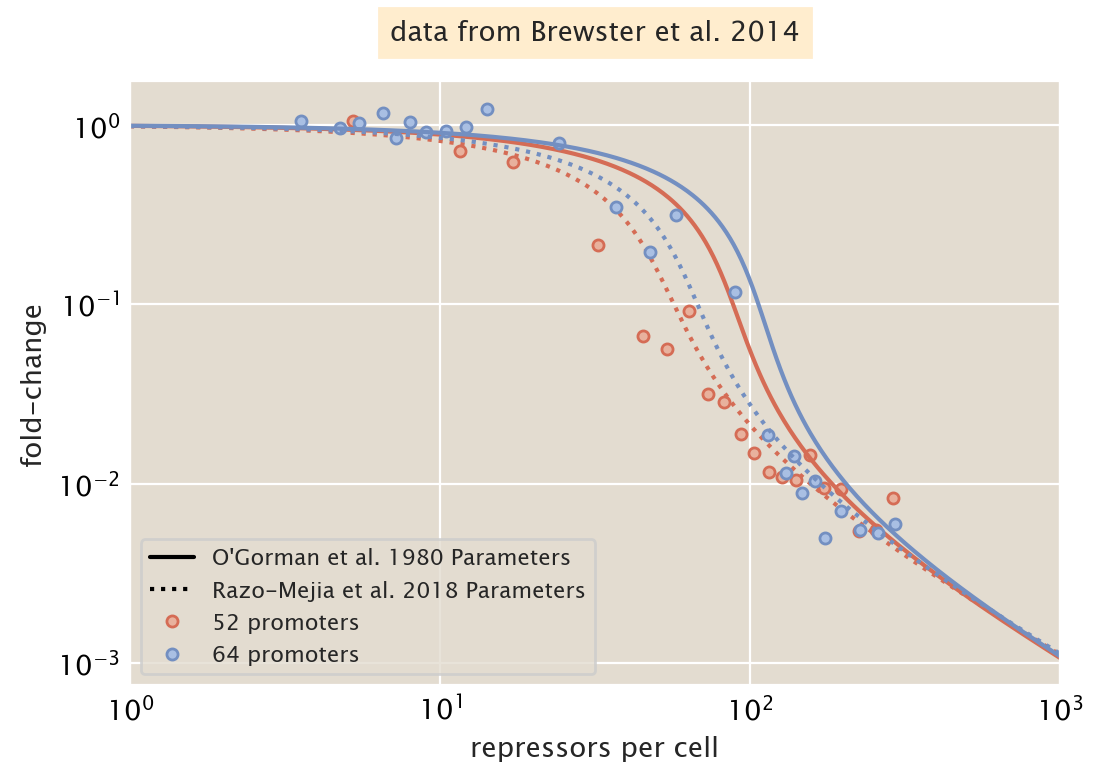

In [217]:
fig, ax = plt.subplots(1, 1, dpi=200)

op_colors = {52:colors['red'], 64:colors['blue']}
face_colors = {52:colors['light_red'], 64:colors['light_blue']}
rep_range = np.logspace(0, 3, 500)
ax.plot([], [], 'k-', label="O'Gorman et al. 1980 Parameters")
ax.plot([], [], 'k:', label='Razo-Mejia et al. 2018 Parameters')
for g, d in fug_data.groupby(['N']):
    ax.loglog(d['repressor'], d['fold_change'], '.', color=op_colors[g], label=f'{int(g)} promoters',
             ms=8, markerfacecolor=face_colors[g])
    
    # Compute the fold-change for each based off of the information.
    fc = matthews_fugacity(rep_range, 0, g, newO1)
    ax.plot(rep_range, fc, '-', color=op_colors[g], label='__nolegend__',
           lw=1.5)
    
    # Compute the fold-change for each based off of the information.
    fc = brewster_fugacity(rep_range, 0, g, -15.3)
    ax.plot(rep_range, fc, ':', color=op_colors[g], label='__nolegend__',
           lw=1.5)

    
ax.legend(fontsize=8)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_xlabel('repressors per cell')
ax.set_ylabel('fold-change')
ax.set_xlim([1, 1E3])
ax.set_title('data from Brewster et al. 2014', fontsize=10, backgroundcolor=colors['pale_yellow'], y=1.04)
plt.savefig('./fugacity_comparison.pdf', bbox_inches='tight')

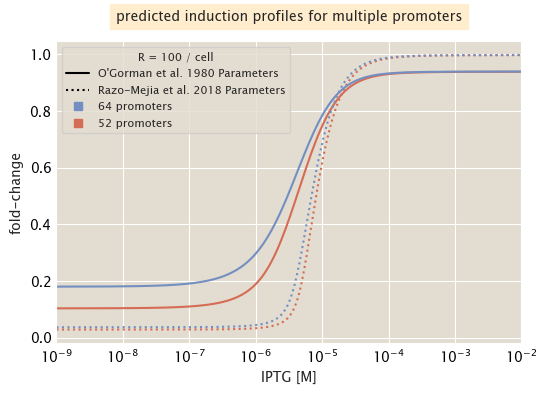

In [209]:
# Plot fugacity induction profiles. 
c_range = np.logspace(-9, -2, 200)
R=100
epRA=-15
N1 = 52
N2 = 64

plt.figure(dpi=100)
plt.plot([], [], 'k-', label="O'Gorman et al. 1980 Parameters")
plt.plot([], [], 'k:', label='Razo-Mejia et al. 2018 Parameters')
plt.plot([], [], 's', color=colors['blue'], label='64 promoters')
plt.plot([], [], 's', color=colors['red'], label='52 promoters')
plt.semilogx(c_range, matthews_fugacity(R, c_range, N1, epRA), '-', color=colors['red'], lw=1.5, label='__nolegend__')
plt.plot(c_range, brewster_fugacity(R, c_range, N1, epRA), ':', color=colors['red'], lw=1.5, label='__nolegend__')
plt.plot(c_range, matthews_fugacity(R, c_range, N2, epRA), '-', color=colors['blue'], lw=1.5, label='__nolegend__')
plt.plot(c_range, brewster_fugacity(R, c_range, N2, epRA), ':', color=colors['blue'], lw=1.5, label='__nolegend__')
leg = plt.legend(fontsize=8, title='R = 100 / cell')
leg.get_title().set_fontsize(8)
plt.xlabel('IPTG [M]', fontsize=10)
plt.ylabel('fold-change', fontsize=10)
plt.title('predicted induction profiles for multiple promoters', fontsize=10, backgroundcolor=colors['pale_yellow'], y=1.04)
plt.xlim([1E-9, 1E-2])
plt.savefig('./predicted_fugacity_profiles.pdf', bbox_inches='tight')

| **Parameter** | **O'Gorman et al. 1980** | **Razo-Mejia et al. 2018**|
|:--:|:--:|:--:|
|$K_A$ | $133\,\mu$M | $139\,\mu$M|
|$K_I$ | $0.4\,\mu$M | $0.53\,\mu$M|
|$\Delta\varepsilon_{AI}$ | $0.35\,k_BT$ | $\geq 4.5 \,k_BT$|


 $$
\text{fold-change} = \left(1 + p_\text{act}(c){R \over N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} + (1 - p_\text{act}(c)){R \over N_{NS}}e^{-\beta(\Delta\varepsilon_{RA} + 7\,k_BT)}\right)^{-1}
$$

$$
\text{fold-change} = {1 \over \lambda_{RA}e^{-\beta\Delta\varepsilon_{RA}} + \lambda_{RI}e^{-\beta(\Delta\varepsilon_{RA} + 7\,k_BT)}}
$$
